Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

# Sentiment Analysis on IMDB Movie Review dataset

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


You will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

You can use this blog for understanding: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [195]:
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from operator import itemgetter
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import string
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
import os



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# MORE IMPORTS
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word

In [0]:
#Confusin matrix plot from CVIR assignment 
def plot_confusion_matrix(conf_mat):
    classes = ['Negative', 'Positive']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

In [0]:
# Copied from CVIR assignment
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.scatter(range(len(history.history['accuracy'])), history.history['accuracy'])
    plt.scatter(range(len(history.history['val_accuracy'])), history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.scatter(range(len(history.history['loss'])), history.history['loss'])
    plt.scatter(range(len(history.history['val_loss'])), history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [199]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All the relevant libraries are imported. 
You are free to change as you please. 
Using the GPU backend is recommended as LSTMs are computationally expensive to train.



## Data handling - exploration and cleaning



In [0]:
df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')


### Data Cleaning - write the techniques you employed and the achieved results

In [0]:
def cleaning_func(data):
  token_gen=ToktokTokenizer()
  lemmer = WordNetLemmatizer()
  #stop_words = set(stopwords.words('english'))  
  #data = re.sub('\[[^]]*\]', '', data)
  #re.sub(r'[^a-zA-z0-9\s]','',data)
  tokened_d = token_gen.tokenize(data)
  table = str.maketrans('', '', string.punctuation)
  tokened_d = [w.translate(table) for w in tokened_d]
  tokened_d = [w.lower() for w in tokened_d]
  
  tokened_d = [w for w in tokened_d if w.isalpha()]
  #tokened_d = [token for token in tokened_d if token.lower() not  in stop_words]
  tokened_d = [w for w in tokened_d if len(w) > 1]
 
  tokened_d =([lemmer.lemmatize(w) for w in tokened_d])
  
  return np.array(tokened_d)

In [0]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [0]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [0]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [0]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [0]:
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    stopword_list = set(stopwords.words('english'))  
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [0]:
# WRITE CODE HERE
# Sample code:
punct = re.compile("[.;:!\'?,\"()\[\]]")
tags = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")


df['review']=([punct.sub("", l) for l in df['review']])
df['review']= ([tags.sub(" ", l) for l in df['review']])
df['review'] = df['review'].apply(denoise_text)
df['review'] = df['review'].apply(remove_special_characters)
df['review']=  df['review'].apply(remove_stopwords)
df['review']=  df['review'].apply(cleaning_func)



In [208]:
df['review']

0        [one, reviewer, mentioned, watching, oz, episo...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, there, family, little, boy, jake, ...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movie, high, art, f...
Name: review, Length: 50000, dtype: object

Write about the techniques used to clean:

All these had been applied in a previous ML assignment

So, I removed punctuation using several ways because simply getting the string.punctuation did not work very well. Then, I removed stop wrods from the nltk libary. After that, words that were only of length 1 were removed because they are usually meaningnless in terms of sentiment classification. Words were converted to lower case becasue well, it shortens the size of your corpus and achieves uniformity. Lemmatization was also applied which is basically converting words to their roots or something and analyzes suffixes prefixes etc. Stemming was tried but it failed. Didn't get good results

### Data Exploration



1.   You are expected to read the dataset into a dataframe.
2.   This is a real world dataset and you will be expected to clean the dataset.

1.   This includes removing trailing spaces and HTML tags.








1.   You are required to report the total number of distinct tokens present in the data set.
2.   Find out the minimum and max length of a review.

An integral part of visualization when it comes to textual data is the generating of a word cloud.

1.   
This task is open-ended and you can use any library of your choice. 
NLTK is one such library. 
2.   
Make sure to keep note of stop words.

##Example:


![alt text](https://getthematic.com/wp-content/uploads/2018/03/Harris-Word-Cloud-e1522406279125.png)




In [0]:
entire_corpus = {}

for i in range(len(df['review'])):
  
  for w in df['review'][i]:
    if w in entire_corpus:
      entire_corpus[w] = +1
    else:
      entire_corpus.update({w:1})


In [210]:
print("The number of distinc tokens in the set are: ", len(entire_corpus))

The number of distinc tokens in the set are:  119712


In [211]:
longest = max(df['review'],key=len)
shortest = min(df['review'],key=len)


print("The longest review is:\n", longest,"\n and it's lenght was ",  len(longest))

print("\nThe shortest review is:\n", shortest,"\n and it's length was ",  len(shortest))

The longest review is:
 ['match' 'tag' 'team' ... 'winner' 'give' 'ppv'] 
 and it's lenght was  1419

The shortest review is:
 ['script' 'story' 'mess'] 
 and it's length was  3


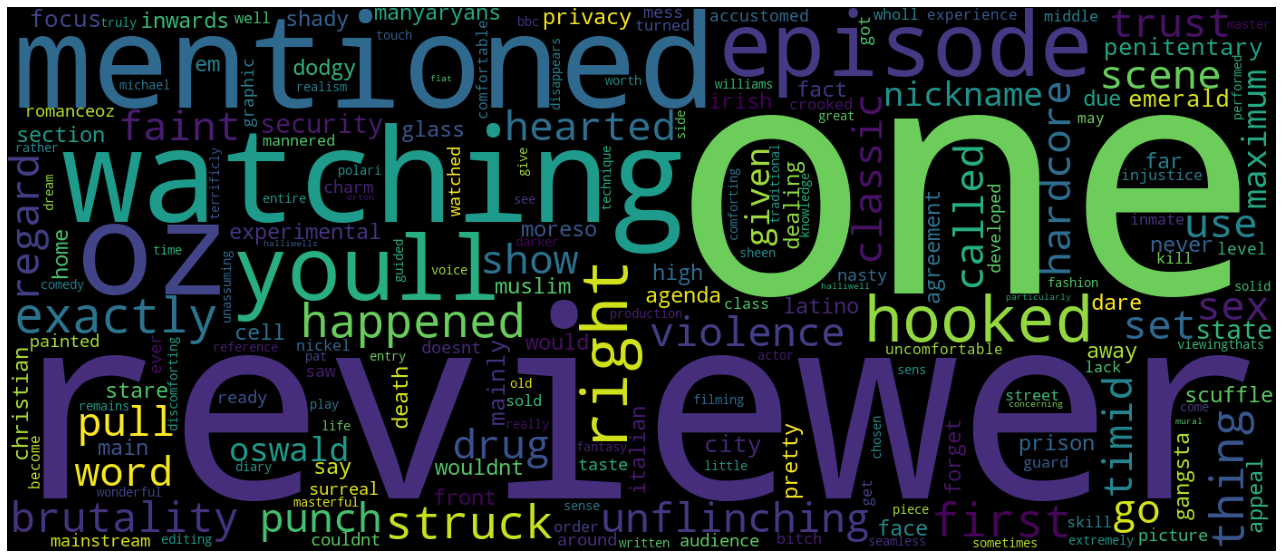

In [13]:
plt.figure(figsize=(32,10))
wc = WordCloud(width=1400,height=600, max_words=200).generate_from_frequencies(entire_corpus)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [0]:
#WRITE CODE HERE

### Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

### Tokenizer
You will need to use fit a tokenizer over your training and testing data.

What does a tokenizer do?
It creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts. You should read up on the documentation before diving into the code. 

You will also be using the the text_to_sequence function will return integers based on a respective tokenizer.

Make sure you **pad** your sequences to max length using sequence.pad_sequences()




In [0]:
# Converting labels to numeric
df["sentiment"] = df["sentiment"].replace("negative",0)
df["sentiment"]=df["sentiment"].replace("positive",1) 


In [176]:
df['review'][3]

array(['basically', 'there', 'family', 'little', 'boy', 'jake', 'think',
       'there', 'zombie', 'closet', 'parent', 'fighting', 'time', 'movie',
       'slower', 'soap', 'opera', 'suddenly', 'jake', 'decides', 'become',
       'rambo', 'kill', 'zombie', 'ok', 'first', 'youre', 'going', 'make',
       'film', 'must', 'decide', 'thriller', 'drama', 'drama', 'movie',
       'watchable', 'parent', 'divorcing', 'arguing', 'like', 'real',
       'life', 'jake', 'closet', 'totally', 'ruin', 'film', 'expected',
       'see', 'boogeyman', 'similar', 'movie', 'instead', 'watched',
       'drama', 'meaningless', 'thriller', 'spot', 'well', 'playing',
       'parent', 'descent', 'dialog', 'shot', 'jake', 'ignore'],
      dtype='<U11')

In [177]:
df["sentiment"]

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [0]:
# WRITE CODE HERE

tkzr = Tokenizer()
for index,words in enumerate(df['review']):
    concated = ' '.join(words)
    df.loc[index,'review'] = concated



In [0]:
sequenced = []

In [0]:
for i in range(len(df['review'])):
  splitted = text_to_word_sequence(df['review'][i])
  sequenced.append(splitted)


In [0]:
sequenced = np.asarray(sequenced)

In [0]:
tkzr.fit_on_texts(sequenced)
sequenced_numeric  =tkzr.texts_to_sequences(sequenced)    


In [183]:
sequenced_numeric[0]

[3,
 1046,
 940,
 66,
 3039,
 176,
 376,
 2924,
 107,
 517,
 492,
 22,
 26,
 2941,
 3039,
 4831,
 13182,
 15,
 471,
 117,
 107,
 255,
 31,
 1558,
 23,
 6054,
 2127,
 10117,
 23,
 923,
 1944,
 2049,
 597,
 273,
 471,
 3454,
 228,
 264,
 255,
 334,
 3039,
 9091,
 265,
 12955,
 6092,
 2317,
 587,
 46618,
 762,
 1267,
 19575,
 396,
 4187,
 1920,
 1018,
 1916,
 1800,
 811,
 231,
 46619,
 14581,
 203,
 3984,
 2902,
 396,
 246,
 59640,
 3755,
 10955,
 6306,
 1160,
 848,
 2240,
 20250,
 19576,
 210,
 3847,
 6555,
 1637,
 7683,
 7369,
 42,
 135,
 151,
 11,
 41,
 189,
 1065,
 23,
 574,
 95,
 31,
 23,
 470,
 2450,
 697,
 97,
 249,
 3771,
 2296,
 162,
 697,
 1142,
 697,
 59641,
 68,
 803,
 98,
 22,
 176,
 48,
 121,
 2941,
 1455,
 2027,
 315,
 41,
 1432,
 197,
 1265,
 966,
 3039,
 104,
 8986,
 203,
 421,
 1254,
 471,
 471,
 5698,
 6346,
 1895,
 11851,
 2724,
 19577,
 4748,
 11851,
 274,
 459,
 10,
 151,
 16,
 6738,
 538,
 531,
 4748,
 544,
 1018,
 4728,
 574,
 350,
 561,
 1167,
 1018,
 384,
 66,
 3

In [0]:
padded_sequences = pad_sequences(sequenced_numeric,maxlen=300)

In [0]:
# Splitting train/test 78/12
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, (df["sentiment"]), test_size=0.1, random_state=42)
# Splitting test/val 90/10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10)

### Embedding layer
You will be importing the embedding layer from Keras.
Embedding layers are common place when handling textual data. 
Word embeddings provide a dense representation of words and their relative meanings.

#### How do they work - via Stack Overflow
Link: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

The output vectors are not computed from the input using any mathematical operation. Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

Hope to see you soon

Nice to see you again

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argumet, of course, determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors.


### Model Engineering

You will be required to engineer three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs

1.   A model with less than 10,000 parameters - the lower the parameters, higher the score (provided accuracy is good)


For each model:

1.   You will be reporting graphs for validation accuracy and training loss.
2.   What hyper-parameters, loss functions, optimizations, initializations were used. This should be clearly stated in your analysis.

~90 percent and above is the desired accuracy. 

For model 3, CLEARLY report the number of parameters.




# LSTM Model

In [0]:
input_dimension = len(entire_corpus) 
output_dimension = 2

In [284]:
X_train.shape[1]

300

In [0]:
# CODE HERE

# Some example code to help you get started
# X_train is your training data 
# input_dim is your dictionary length, output_dim is the length is the dimension of the dense embedding, you can choose whatever works best for you, starting with 2.

lstm= Sequential()
lstm.add(Embedding(input_dimension, output_dimension, input_length=X_train.shape[1]))
#lstm.add(Dropout(0.3))
#lstm.add(LSTM(128 , recurrent_dropout=0.2))

lstm.add(LSTM(200))
#lstm.add(Dropout(0.3))
lstm.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.002, beta_1=0.5, decay=8e-8)
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


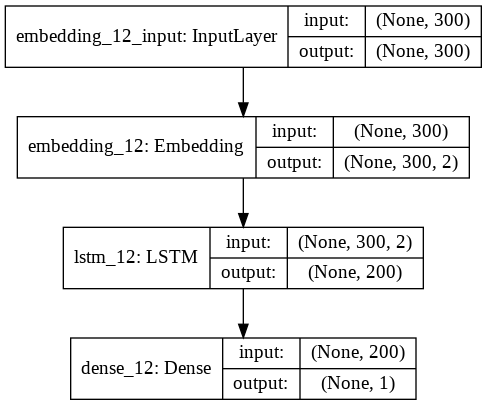

In [68]:
plot_model(lstm,show_shapes=True)

In [0]:
# Callbacks for the umpteenth time
lstm.name = 'LSTM'
# Callbacks for LSTM model
if not os.path.exists('./'+lstm.name):
    os.mkdir(lstm.name)


In [0]:
checkpoint = ModelCheckpoint(lstm.name+'/'+lstm.name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(lstm.name+'/logs.csv', separator=',', append=True)


callbacks = [checkpoint, cvslogger]

In [0]:
def batch_gen(df,labels,batch_size = 32):

  while True:
    start = 0
    stop = batch_size

    total_batches = int(np.ceil(df.shape[0] / batch_size))

    for i in range(total_batches):
      if i == total_batches-1:
          yield (df[start:],labels[start:])
      else:        
          yield (df[start:stop],labels[start:stop])
      start = stop
      stop+= batch_size

In [0]:
t_generator=batch_gen(X_train,y_train, 32)
v_generator=batch_gen(X_val,y_val,32)
#te_generator=batch_gen(X_test,y_test,32)

In [0]:
# Loading weights


lstm.load_weights('/content/LSTM/LSTM-01-0.31.h5')

In [295]:
lstm_stats =lstm.fit_generator(t_generator, epochs=1, steps_per_epoch= np.ceil(len(X_train)  / 32),
                           validation_data=v_generator,
                           validation_steps = np.ceil(len(X_val)/32) ,
                           callbacks=callbacks, verbose=1)

Epoch 1/1
 946/1266 [=====================>........] - ETA: 4:04 - loss: 0.6975 - accuracy: 0.5438

KeyboardInterrupt: ignored

In [194]:
lstm_stats =lstm.fit_generator(t_generator, epochs=1, steps_per_epoch= np.ceil(len(X_train)  / 32),
                           validation_data=v_generator,
                           validation_steps = np.ceil(len(X_val)/32) ,
                           callbacks=callbacks, verbose=1)

Epoch 1/1
1266/1266 [==============================] - 986s 779ms/step - loss: 0.2345 - accuracy: 0.9105 - val_loss: 0.3587 - val_accuracy: 0.8629

Epoch 00001: val_loss did not improve from 0.24577


In [146]:
lstm_preds = lstm.predict(X_test, batch_size=32, verbose=1)

6000/6000 [==============================] - 7s 1ms/step


In [147]:
lstm_preds

array([[0.14709106],
       [0.97028   ],
       [0.047006  ],
       ...,
       [0.97481966],
       [0.07720364],
       [0.02327643]], dtype=float32)

In [0]:
lstm_predictions =np.where(lstm_preds>=0.5,1,0)
lstm_predictions = lstm_predictions.reshape(1,-1)[0]

In [149]:
lstm_predictions

array([0, 1, 0, ..., 1, 0, 0])

In [150]:
lstm_preds.shape

(6000, 1)

In [0]:
classes = ['Negative','Positive']

In [152]:
len(lstm_predictions)

6000

In [0]:
classification_rep = classification_report(lstm_predictions, y_test, target_names=classes)

In [154]:
print(classification_rep)

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      3054
    Positive       0.87      0.89      0.88      2946

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



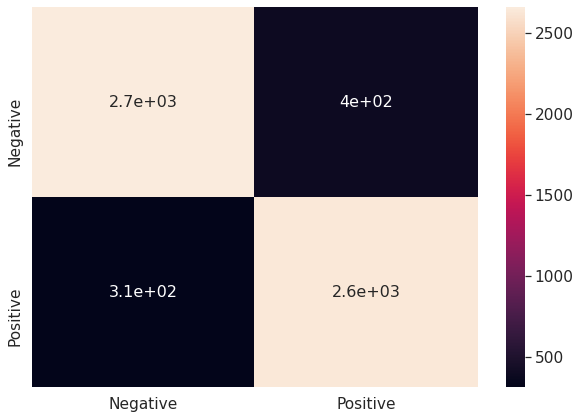

In [155]:

conf_mat=confusion_matrix(lstm_predictions, y_test)  
plot_confusion_matrix(conf_mat)

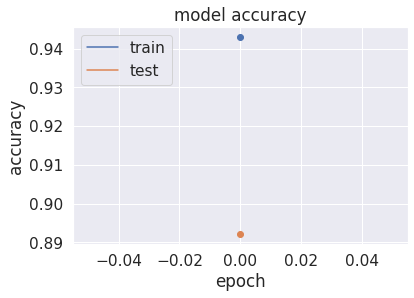

In [156]:
plot_accuracy(lstm_stats)

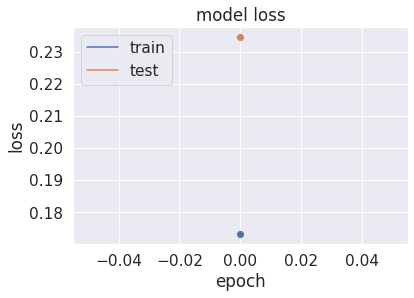

In [157]:
plot_loss(lstm_stats)

# Analysis

I trained the models for 1 epoch so that I could change parameters if I wanted to after just 1 epoch.
The accuracy did not go higher than 88. IF I trained more, it would overfit the data and accuracy would drop. My accuracy on the validation set was 0.91 for this for the most part so overfitting did not really occur. 

The resuls for the confusion matrices show that our model achieved a good balance between precision and recall as well. 


Binary cross-entropy loss function was used whereas I used the adam optimizer with a 0.002 learning rate in the beginning which was then reduced after a couple of epochs. I tried different maxlens ranging from 350 to 240 to 100 and the results didn't really matter much. Other than that, I used dropout to prevent overfitting. Output dimensions were also varied from 16 to 2 and the results didn't change much.

#Bi-Directional LSTM Model

In [0]:
input_dim=len(entire_corpus)
output_dim=16
bi_lstm= Sequential()

bi_lstm.add(Embedding(input_dim, output_dim, input_length=X_train.shape[1]))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Dense(1, activation='sigmoid'))

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
bi_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

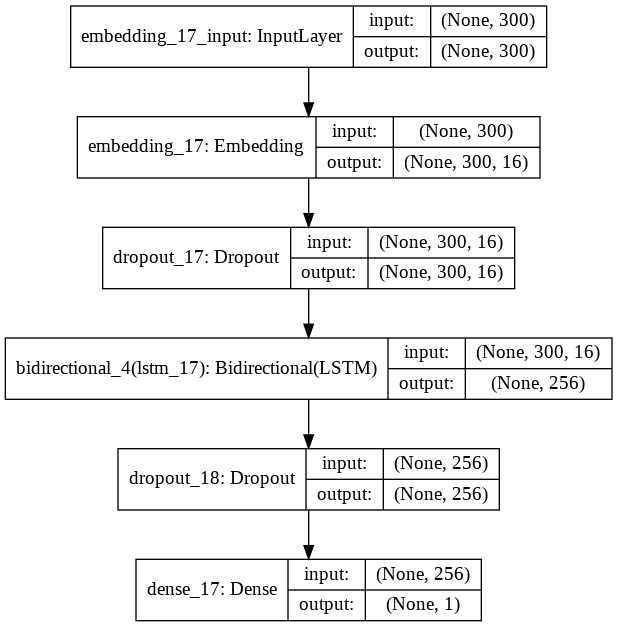

In [89]:
plot_model(bi_lstm,show_shapes=True)

In [0]:
# Callbacks for the umpteenth time
bi_lstm.name = 'Bi_LSTM'
# Callbacks for LSTM model
if not os.path.exists('./'+bi_lstm.name):
    os.mkdir(bi_lstm.name)


In [0]:
checkpoint = ModelCheckpoint(bi_lstm.name+'/'+bi_lstm.name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(bi_lstm.name+'/logs.csv', separator=',', append=True)


callbacks = [checkpoint, cvslogger]

In [0]:
t_generator=batch_gen(X_train,y_train, 32)
v_generator=batch_gen(X_val,y_val,32)
#te_generator=batch_gen(X_test,y_test,32)

In [0]:
# Loading weights


bi_lstm.load_weights('/content/Bi_LSTM/Bi_LSTM-01-0.39.h5')

In [116]:
bi_lstm_stats =bi_lstm.fit_generator(t_generator, epochs=1, steps_per_epoch= np.ceil(len(X_train)  / 32),
                           validation_data=v_generator,
                           validation_steps = np.ceil(len(X_val)/32) ,
                           callbacks=callbacks, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
 314/1266 [======>.......................] - ETA: 24:56 - loss: 0.2865 - accuracy: 0.8885

KeyboardInterrupt: ignored

In [96]:
bi_lstm_preds = bi_lstm.predict(X_test, batch_size=32, verbose=1)

5000/5000 [==============================] - 19s 4ms/step


In [0]:
bi_lstm_preds

array([[0.14709106],
       [0.97028   ],
       [0.047006  ],
       ...,
       [0.97481966],
       [0.07720364],
       [0.02327643]], dtype=float32)

In [0]:
bi_lstm_predictions =np.where(bi_lstm_preds>=0.5,1,0)
bi_lstm_predictions = bi_lstm_predictions.reshape(1,-1)[0]

In [0]:
bi_lstm_predictions

array([0, 1, 0, ..., 1, 0, 0])

In [98]:
bi_lstm_preds.shape

(5000, 1)

In [0]:

classes = ['Negative','Positive']

In [0]:

classification_rep = classification_report(bi_lstm_predictions, y_test, target_names=classes)

In [101]:
print(classification_rep)

              precision    recall  f1-score   support

    Negative       0.86      0.83      0.85      2566
    Positive       0.83      0.86      0.84      2434

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



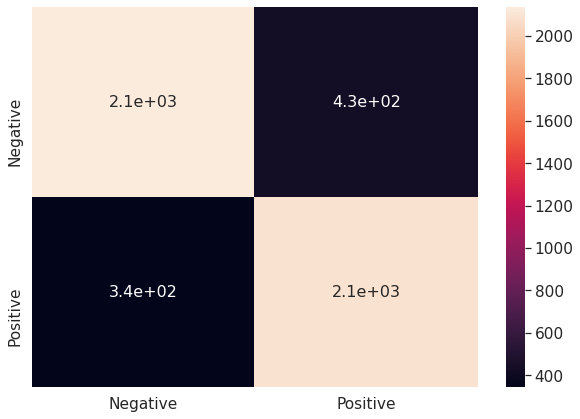

In [102]:

conf_mat=confusion_matrix(bi_lstm_predictions, y_test)  
plot_confusion_matrix(conf_mat)

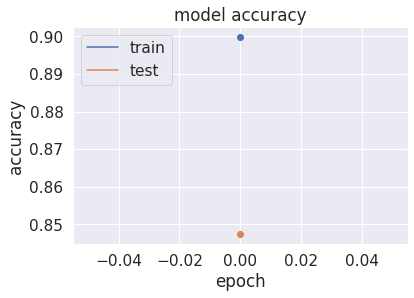

In [105]:
plot_accuracy(bi_lstm_stats)

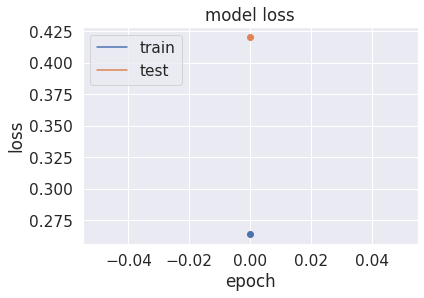

In [104]:
plot_loss(bi_lstm_stats)

# Analysis for Birection LSTM



Again, I trained the models for 1 epoch so that I could change parameters if I wanted to after just 1 epoch.
The accuracy did not go higher than 88. IF I trained more, it would overfit the data and accuracy would drop. My accuracy on the validation set was 0.91 for this for the most part so overfitting did not really occur. 

The resuls for the confusion matrices show that our model achieved a good balance between precision and recall as well. 


Binary cross-entropy loss function was used whereas I used the adam optimizer with a 0.002 learning rate in the beginning which was then reduced after a couple of epochs. Also, I used RMSprop in between to try to reduce the loss. I tried different maxlens ranging from 350 to 240 to 100 and the results didn't really matter much. Other than that, I used dropout to prevent overfitting. Output dimensions were also varied from 16 to 2 and the results didn't change much. Also, bi-directional took almost twice the time to train which was expected 

# Less Than 10k Parameters Model

In [0]:
input_dimension = 3900
output_dimension =2

In [0]:
lstm_k= Sequential()
lstm_k.add(Embedding(input_dimension, output_dimension, input_length=X_train.shape[1]))
lstm_k.add(Dropout(0.1))
lstm_k.add(  Bidirectional(LSTM(15 , recurrent_dropout=0.1))   )
lstm_k.add(Dropout(0.1))
lstm_k.add(Dense(1, activation='sigmoid'))
adam = Adam(lr=0.002, beta_1=0.5, decay=8e-8)
lstm_k.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

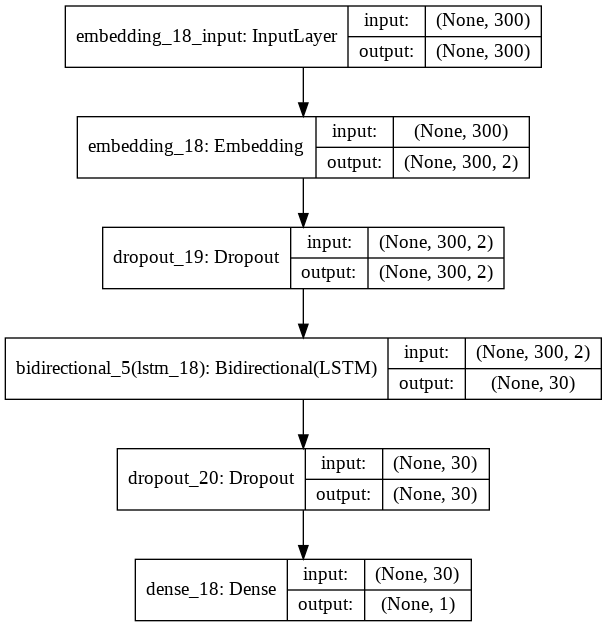

In [108]:
plot_model(lstm_k,show_shapes=True)

In [225]:
lstm_k.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 300, 2)            7800      
_________________________________________________________________
dropout_25 (Dropout)         (None, 300, 2)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 30)                2160      
_________________________________________________________________
dropout_26 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 9,991
Trainable params: 9,991
Non-trainable params: 0
_________________________________________________________________


No. of parameters for our constrained model : 

In [0]:
# Callbacks for the umpteenth time
lstm_k.name = 'LSTM_K'
# Callbacks for LSTM model
if not os.path.exists('./'+lstm_k.name):
    os.mkdir(lstm_k.name)


In [0]:
checkpoint = ModelCheckpoint(lstm_k.name+'/'+lstm_k.name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(lstm_k.name+'/logs.csv', separator=',', append=True)


callbacks = [checkpoint, cvslogger]

In [0]:
t_generator=batch_gen(X_train,y_train, 32)
v_generator=batch_gen(X_val,y_val,32)


In [0]:
# Loading weights


lstm_k.load_weights('/content/drive/My Drive/BILSTM-10-0.26.h5')

In [274]:
lstm_k_stats =lstm_k.fit_generator(t_generator, epochs=1, steps_per_epoch= 1,
                           validation_data=v_generator,
                           validation_steps = np.ceil(len(X_val)/32) ,
                           callbacks=callbacks, verbose=1)

Epoch 1/1
1/1 [==============================] - 17s 17s/step - loss: 0.9730 - accuracy: 0.6875 - val_loss: 0.6856 - val_accuracy: 0.6249

Epoch 00001: val_loss did not improve from 0.68420


In [0]:
lstm_k_preds = lstm_k.predict(X_test, batch_size=32, verbose=1)

6000/6000 [==============================] - 7s 1ms/step


In [0]:
lstm_k_predictions =np.where(lstm_k_preds>=0.5,1,0)
lstm_k_predictions = lstm_k_predictions.reshape(1,-1)[0]

In [0]:
classes = ['Negative','Positive']

In [0]:
classification_rep = classification_report(lstm_k_predictions, y_test, target_names=classes)

In [0]:
print(classification_rep)

In [0]:

conf_mat=confusion_matrix(lstm_k_predictions, y_test)  
plot_confusion_matrix(conf_mat)

In [0]:
plot_accuracy(lstm_k_stats)

In [0]:
plot_loss(lstm_k_stats)

# Analysis for Birectional LSTM with less than 10 Parameters


Again, I trained the models for 1 epoch so that I could change parameters if I wanted to after just 1 epoch.
The accuracy did not go higher than 88. IF I trained more, it would overfit the data and accuracy would drop. My accuracy on the validation set was 0.91 for this for the most part so overfitting did not really occur. 

The resuls for the confusion matrices show that our model achieved a good balance between precision and recall as well. 


Binary cross-entropy loss function was used whereas I used the adam optimizer with a 0.002 learning rate in the beginning which was then reduced after a couple of epochs. Also, I used RMSprop in between to try to reduce the loss. I tried different maxlens ranging from 350 to 240 to 100 and the results didn't really matter much. Other than that, I used dropout to prevent overfitting. Output dimensions were also varied from 16 to 2 and the results didn't change much.

For this model, I let the input dimensions be 3900 and outptut be 2 to keep the parameter size small. Despite this, training still took pretty long

### Model Predictions. For your best performing model

Come up with ten sample sentences NOT part of the original data set. 
Use model.predict() to generate predictions and report positive or negative sentiment.

In [0]:
one = "ive watched this movie atleast 20 times since it came out it is perhaps the greatest movie of all time"
two = "this movie a complete waste of time never going to watch it again"
three = "this movie deserves an oscar"
four = "i hope the entire cast dies rubbish movie"
five = 'they could have done better the acting sucked'

In [0]:
labels = [1,0,1,0,0]
reviews_new = np.array([one,two,three,four,five])

In [0]:
sequenced = []

In [0]:
for i in range(len(reviews_new)):
  splitted = text_to_word_sequence(reviews_new[i])
  sequenced.append(splitted)


In [0]:
sequenced = np.asarray(sequenced)

In [0]:
tkzr.fit_on_texts(sequenced)
sequenced_numeric  =tkzr.texts_to_sequences(sequenced)    


In [0]:
sequenced_numeric[0]

In [0]:
bi_lstm_preds = lstm_k.predict(sequenced_numeric) 

In [0]:
bi_lstm_predictions =np.where(bi_lstm_preds>=0.5,1,0)
bi_lstm_predictions = bi_lstm_predictions.reshape(1,-1)[0]
classes = ['Negative','Positive']
classification_rep = classification_report(bi_lstm_predictions, y_test, target_names=classes)

In [0]:
print(classification_rep)